In [1]:
import numpy as np
import pandas as pd
import time
from time import time
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px

# NLP
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# ML and preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold,
    cross_val_score,
    cross_val_predict
)
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    f1_score,
    classification_report
)
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
df = pd.read_csv('Stress.csv')

In [4]:
df.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


In [6]:
df['subreddit'].value_counts()

subreddit
ptsd                584
relationships       552
anxiety             503
domesticviolence    316
assistance          289
survivorsofabuse    245
homeless            168
almosthomeless       80
stress               64
food_pantry          37
Name: count, dtype: int64

In [7]:
df.isnull().sum()

subreddit           0
post_id             0
sentence_range      0
text                0
label               0
confidence          0
social_timestamp    0
dtype: int64

In [8]:
df.describe()

,label,confidence,social_timestamp
count,2838.000000,2838.000000,2.838000e+03
mean,0.524313,0.808972,1.518107e+09
std,0.499497,0.177038,1.552209e+07
min,0.000000,0.428571,1.483274e+09
25%,0.000000,0.600000,1.509698e+09
50%,1.000000,0.800000,1.517066e+09
75%,1.000000,1.000000,1.530898e+09
max,1.000000,1.000000,1.542592e+09


## EDA ##

In [9]:
lst = ['subreddit', 'label']

for column in lst:
    a = df[column].value_counts()
    lbl = a.index

    fig = px.pie(
        names=lbl,
        values=a,
        title=f"{column}_Distribution",
        hole=0.3,  
    )
    
    fig.show()

In [10]:
fig = px.bar(
    data_frame=df,
    x='subreddit',
    color='label',
    title='Subreddit-wise Stress Count',
    color_discrete_sequence=px.colors.sequential.Plasma,  
    labels={'x': 'Subreddit', 'count': 'Count'},  
)

fig.update_layout(
    xaxis_title='Subreddit',
    yaxis_title='Count',
    title_font_size=20,
    width=1000,
    height=600,
)

fig.show()

## Text Preprocessing ##

In [11]:
def preprocess(text, remove_digits=True):
    """
    Preprocess text by removing special characters, URLs, emails, and stopwords
    """
    if not text or pd.isna(text):
        return ''
    
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove special characters and digits
    text = re.sub('\W+', ' ', text)
    text = re.sub('\s+', ' ', text)
    if remove_digits:
        text = re.sub("(?<!\w)\d+", "", text)

    # Remove punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    text = ''.join(nopunc)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])

In [22]:
def preprocess(text, remove_digits=True):
    """
    Preprocess text by removing special characters, URLs, emails, and stopwords
    """
    if not text or pd.isna(text):
        return ''
    
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove special characters and digits
    text = re.sub('\W+', ' ', text)
    text = re.sub('\s+', ' ', text)
    if remove_digits:
        text = re.sub("(?<!\w)\d+", "", text)

    # Remove punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    text = ''.join(nopunc)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    
    return text


In [23]:
def lemmatize(text):
    """
    Lemmatize words to their base form
    """
    if not text.strip():  # If text is empty or whitespace
        return ''
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmas)

In [24]:
def clean_text(text):
    """
    Complete text cleaning pipeline
    """
    text = preprocess(text)
    text = lemmatize(text)
    return text

In [25]:
df['clean_text'] = df['text'].apply(clean_text)

In [26]:
df.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,clean_text
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353,said felt way suggeted go rest trigger ahead y...
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817,hey r assistance sure right place post go curr...
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605,mom hit newspaper shocked would know like play...
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555,met new boyfriend amazing kind sweet good stud...
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005,october domestic violence awareness month dome...


## Model Building ##

In [27]:
def model_lr_tf(x_train, x_test, y_train, y_test):
    global acc_lr_tf,f1_lr_tf
    # Text to vector transformation 
    vector = TfidfVectorizer()
    x_train = vector.fit_transform(x_train)
    x_test = vector.transform(x_test)
 
    ovr = LogisticRegression()
    
    #fitting training data into the model & predicting
    t0 = time()

    ovr.fit(x_train, y_train)
    y_pred = ovr.predict(x_test)

    # Model Evaluation
    
    conf=confusion_matrix(y_test,y_pred)
    acc_lr_tf=accuracy_score(y_test,y_pred)
    f1_lr_tf=f1_score(y_test,y_pred,average='weighted')
    print('Time :',time()-t0)
    print('Accuracy: ',acc_lr_tf)
    print(10*'===========')
    print('Confusion Matrix: \n',conf)
    print(10*'===========')
    print('Classification Report: \n',classification_report(y_test,y_pred))
    return y_test,y_pred,acc_lr_tf

def model_nb_tf(x_train, x_test, y_train, y_test):
    global acc_nb_tf,f1_nb_tf
    # Text to vector transformation 
    vector = TfidfVectorizer()
    x_train = vector.fit_transform(x_train)
    x_test = vector.transform(x_test)

    ovr = MultinomialNB()
    
    #fitting training data into the model & predicting
    t0 = time()
    
    ovr.fit(x_train, y_train)
    
    y_pred = ovr.predict(x_test)

    # Model Evaluation
    conf=confusion_matrix(y_test,y_pred)
    acc_nb_tf=accuracy_score(y_test,y_pred)
    f1_nb_tf=f1_score(y_test,y_pred,average='weighted')
    print('Time : ',time()-t0)
    print('Accuracy: ',acc_nb_tf)
    print(10*'===========')
    print('Confusion Matrix: \n',conf)
    print(10*'===========')
    print('Classification Report: \n',classification_report(y_test,y_pred))
    
    return y_test,y_pred,acc_nb_tf
def model_dt_tf(x_train, x_test, y_train, y_test):
    global acc_dt_tf,f1_dt_tf
    # Text to vector transformation 
    vector = TfidfVectorizer()
    x_train = vector.fit_transform(x_train)
    x_test = vector.transform(x_test)
    
    ovr = DecisionTreeClassifier(random_state=1)
    
    #fitting training data into the model & predicting
    t0 = time()
    
    ovr.fit(x_train, y_train)
    y_pred = ovr.predict(x_test)

    # Model Evaluation
    conf=confusion_matrix(y_test,y_pred)
    acc_dt_tf=accuracy_score(y_test,y_pred)
    f1_dt_tf=f1_score(y_test,y_pred,average='weighted')
    print('Time : ',time()-t0)
    print('Accuracy: ',acc_dt_tf)
    print(10*'===========')
    print('Confusion Matrix: \n',conf)
    print(10*'===========')
    print('Classification Report: \n',classification_report(y_test,y_pred))
    
    return y_test,y_pred,acc_dt_tf

def model_knn_tf(x_train, x_test, y_train, y_test):
    global acc_knn_tf,f1_knn_tf
    # Text to vector transformation 
    vector = TfidfVectorizer()
    x_train = vector.fit_transform(x_train)
    x_test = vector.transform(x_test)
    
    ovr = KNeighborsClassifier()
    
    #fitting training data into the model & predicting
    t0 = time()
    
    ovr.fit(x_train, y_train)
    y_pred = ovr.predict(x_test)

    # Model Evaluation
    conf=confusion_matrix(y_test,y_pred)
    acc_knn_tf=accuracy_score(y_test,y_pred)
    f1_knn_tf=f1_score(y_test,y_pred,average='weighted')
    print('Time : ',time()-t0)
    print('Accuracy: ',acc_knn_tf)
    print(10*'===========')
    print('Confusion Matrix: \n',conf)
    print(10*'===========')
    print('Classification Report: \n',classification_report(y_test,y_pred))

def model_rf_tf(x_train, x_test, y_train, y_test):
    global acc_rf_tf,f1_rf_tf
    # Text to vector transformation 
    vector = TfidfVectorizer()
    x_train = vector.fit_transform(x_train)
    x_test = vector.transform(x_test)
    
    ovr = RandomForestClassifier(random_state=1)
    
    #fitting training data into the model & predicting
    t0 = time()
    
    ovr.fit(x_train, y_train)
    y_pred = ovr.predict(x_test)

    # Model Evaluation
    conf=confusion_matrix(y_test,y_pred)
    acc_rf_tf=accuracy_score(y_test,y_pred)
    f1_rf_tf=f1_score(y_test,y_pred,average='weighted')
    print('Time : ',time()-t0)
    print('Accuracy: ',acc_rf_tf)
    print(10*'===========')
    print('Confusion Matrix: \n',conf)
    print(10*'===========')
    print('Classification Report: \n',classification_report(y_test,y_pred))

def model_ab_tf(x_train, x_test, y_train, y_test):
    global acc_ab_tf,f1_ab_tf
    # Text to vector transformation 
    vector = TfidfVectorizer()
    x_train = vector.fit_transform(x_train)
    x_test = vector.transform(x_test)
    
    ovr = AdaBoostClassifier(random_state=1)
    
    #fitting training data into the model & predicting
    t0 = time()
    
    ovr.fit(x_train, y_train)
    y_pred = ovr.predict(x_test)

    # Model Evaluation
    conf=confusion_matrix(y_test,y_pred)
    acc_ab_tf=accuracy_score(y_test,y_pred)
    f1_ab_tf=f1_score(y_test,y_pred,average='weighted')
    print('Time : ',time()-t0)
    print('Accuracy: ',acc_ab_tf)
    print(10*'===========')
    print('Confusion Matrix: \n',conf)
    print(10*'===========')
    print('Classification Report: \n',classification_report(y_test,y_pred))

## Model Evaluation ##
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    t0 = time()
    
    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f'Model: {model_name}')
    print(f'Time: {time() - t0:.2f}s')
    print(f'Accuracy: {acc:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('Confusion Matrix:\n', conf)
    print('Classification Report:\n', classification_report(y_test, y_pred))
    print('='*50)
    
    return acc, f1

## model performance comparsion ##

In [28]:
# Prepare data
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize lists to store metrics
models = []
accuracies = []
f1_scores = []

# Run all models
print("Logistic Regression:")
model_lr_tf(X_train, X_test, y_train, y_test)
models.append('Logistic Regression')
accuracies.append(acc_lr_tf)
f1_scores.append(f1_lr_tf)

print("\nMultinomial Naive Bayes:")
model_nb_tf(X_train, X_test, y_train, y_test)
models.append('Multinomial NB')
accuracies.append(acc_nb_tf)
f1_scores.append(f1_nb_tf)

print("\nDecision Tree:")
model_dt_tf(X_train, X_test, y_train, y_test)
models.append('Decision Tree')
accuracies.append(acc_dt_tf)
f1_scores.append(f1_dt_tf)

print("\nKNN:")
model_knn_tf(X_train, X_test, y_train, y_test)
models.append('KNN')
accuracies.append(acc_knn_tf)
f1_scores.append(f1_knn_tf)

print("\nRandom Forest:")
model_rf_tf(X_train, X_test, y_train, y_test)
models.append('Random Forest')
accuracies.append(acc_rf_tf)
f1_scores.append(f1_rf_tf)

print("\nAdaBoost:")
model_ab_tf(X_train, X_test, y_train, y_test)
models.append('Adaptive Boosting')
accuracies.append(acc_ab_tf)
f1_scores.append(f1_ab_tf)

Logistic Regression:
Time : 0.024002552032470703
Accuracy:  0.7394366197183099
Confusion Matrix: 
 [[273 141]
 [ 81 357]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.66      0.71       414
           1       0.72      0.82      0.76       438

    accuracy                           0.74       852
   macro avg       0.74      0.74      0.74       852
weighted avg       0.74      0.74      0.74       852


Multinomial Naive Bayes:
Time :  0.007769346237182617
Accuracy:  0.6326291079812206
Confusion Matrix: 
 [[111 303]
 [ 10 428]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.27      0.41       414
           1       0.59      0.98      0.73       438

    accuracy                           0.63       852
   macro avg       0.75      0.62      0.57       852
weighted avg       0.75      0.63      0.58       852


Decision Tree:
Time :  0.8504669666290283
Acc

## Create comparison table ##

In [29]:
tbl = pd.DataFrame({
	'Model': models,
	'Accuracy': accuracies,
	'F1_Score': f1_scores
})
tbl.set_index('Model', inplace=True)
tbl
tbl.sort_values('F1_Score',ascending=False)
## Cross Validation To Avoid Overfitting ##
import statistics as st
vector = TfidfVectorizer()

x_train_v = vector.fit_transform(X_train)
x_test_v  = vector.transform(X_test)

## Model Building ##

In [30]:
lr =LogisticRegression()
mnb=MultinomialNB()
dct=DecisionTreeClassifier(random_state=1)
knn=KNeighborsClassifier()
rf=RandomForestClassifier(random_state=1)
ab=AdaBoostClassifier(random_state=1)
m  =[lr,mnb,dct,knn,rf,ab]
model_name=['Logistic R','MultiNB','DecTRee','KNN','R forest','Ada Boost']
results, mean_results, p, f1_test=list(),list(),list(),list()

#Model fitting,cross-validating and evaluating performance
def algor(model):
    print('\n',i)
    pipe=Pipeline([('model',model)])
    pipe.fit(x_train_v,y_train)
    cv=StratifiedKFold(n_splits=5)
    n_scores=cross_val_score(pipe,x_train_v,y_train,scoring='f1_weighted',cv=cv,n_jobs=-1,error_score='raise') # As it is an Imbalance data so f1 score will give a better accuracy than normal accuracy.
    results.append(n_scores)
    mean_results.append(st.mean(n_scores))
    print('f1-Score(train): mean= (%.3f), min=(%.3f)) ,max= (%.3f), stdev= (%.3f)'%(st.mean(n_scores), min(n_scores), max(n_scores),np.std(n_scores)))
    y_pred=cross_val_predict(model,x_train_v,y_train,cv=cv)
    p.append(y_pred)
    f1=f1_score(y_train,y_pred, average = 'weighted')
    f1_test.append(f1)
    print('f1-Score(test): %.4f'%(f1))

for i in m:
    algor(i)
    


 LogisticRegression()
f1-Score(train): mean= (0.766), min=(0.753)) ,max= (0.788), stdev= (0.012)
f1-Score(test): 0.7657

 MultinomialNB()
f1-Score(train): mean= (0.620), min=(0.605)) ,max= (0.635), stdev= (0.011)
f1-Score(test): 0.6202

 DecisionTreeClassifier(random_state=1)
f1-Score(train): mean= (0.630), min=(0.614)) ,max= (0.646), stdev= (0.012)
f1-Score(test): 0.6303

 KNeighborsClassifier()
f1-Score(train): mean= (0.669), min=(0.638)) ,max= (0.694), stdev= (0.020)
f1-Score(test): 0.6689

 RandomForestClassifier(random_state=1)
f1-Score(train): mean= (0.726), min=(0.705)) ,max= (0.762), stdev= (0.020)
f1-Score(test): 0.7258

 AdaBoostClassifier(random_state=1)
f1-Score(train): mean= (0.692), min=(0.667)) ,max= (0.708), stdev= (0.014)
f1-Score(test): 0.6921


## Model comparison By Visualizing  ##

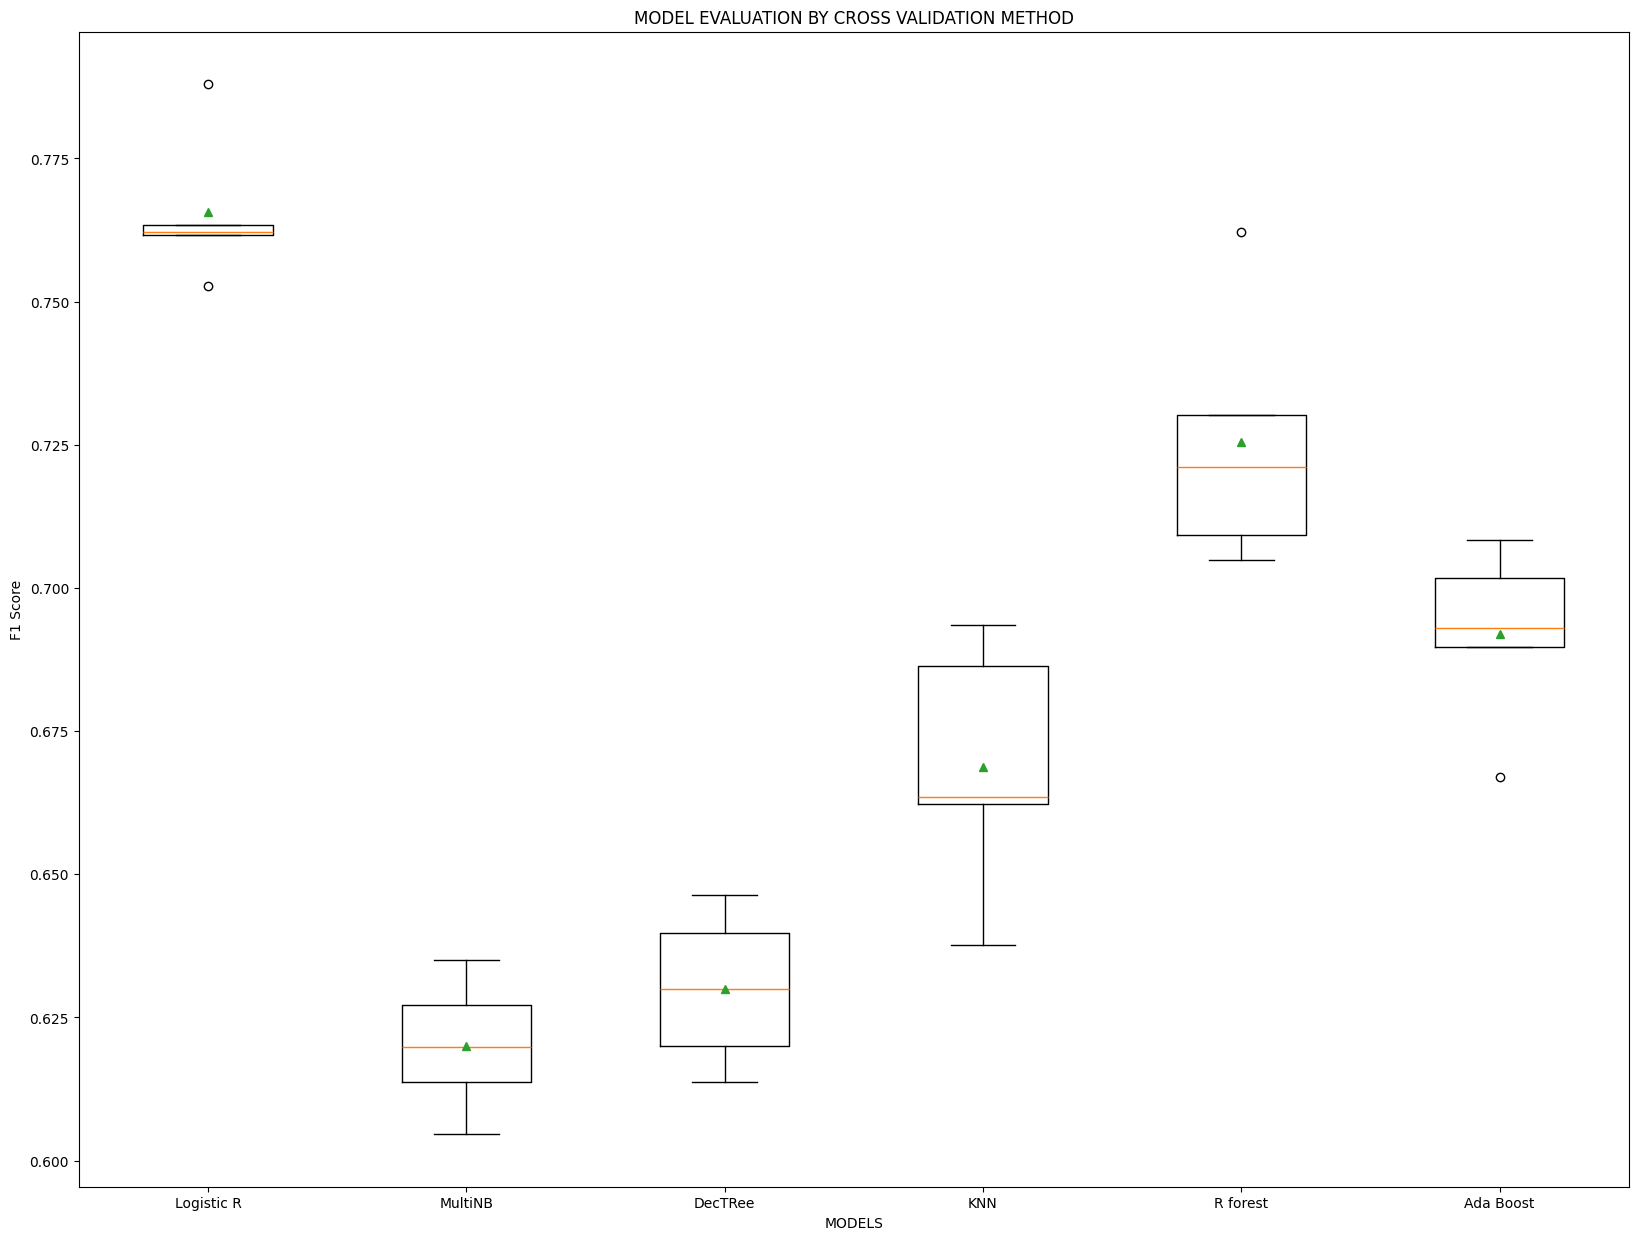

In [31]:
fig=plt.subplots(figsize=(20,15))
plt.title('MODEL EVALUATION BY CROSS VALIDATION METHOD')
plt.xlabel('MODELS')
plt.ylabel('F1 Score')
plt.boxplot(results,labels=model_name,showmeans=True)
plt.show()

As F1 score of the models are coming quite simmmilar by both methods. So now we are applying Leave One Out method to build the best performed model

In [32]:
x=df['clean_text']
y=df['label']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=1)

In [33]:
vector = TfidfVectorizer()
x_train = vector.fit_transform(x_train)
x_test = vector.transform(x_test)
model_lr_tf=LogisticRegression()

model_lr_tf.fit(x_train,y_train)
y_pred=model_lr_tf.predict(x_test)
# Model Evaluation
    
conf=confusion_matrix(y_test,y_pred)
acc_lr=accuracy_score(y_test,y_pred)
f1_lr=f1_score(y_test,y_pred,average='weighted')
print('Accuracy: ',acc_lr)
print('F1 Score: ',f1_lr)
print(10*'===========')
print('Confusion Matrix: \n',conf)
print(10*'===========')
print('Classification Report: \n',classification_report(y_test,y_pred))

Accuracy:  0.7370892018779343
F1 Score:  0.7372521643189369
Confusion Matrix: 
 [[286 108]
 [116 342]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.71      0.73      0.72       394
           1       0.76      0.75      0.75       458

    accuracy                           0.74       852
   macro avg       0.74      0.74      0.74       852
weighted avg       0.74      0.74      0.74       852



## Word Clouds of Stressed & Non-stressed words ##

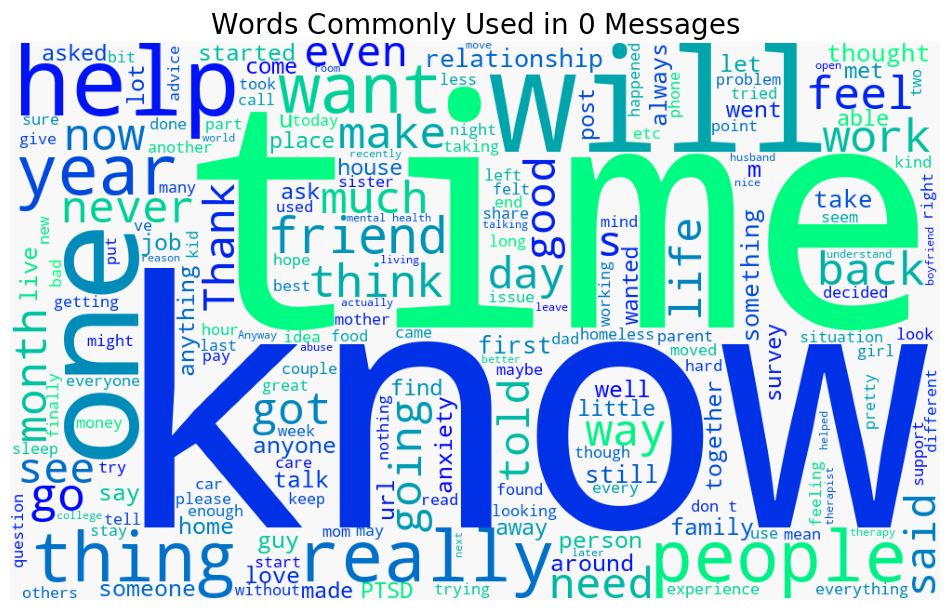

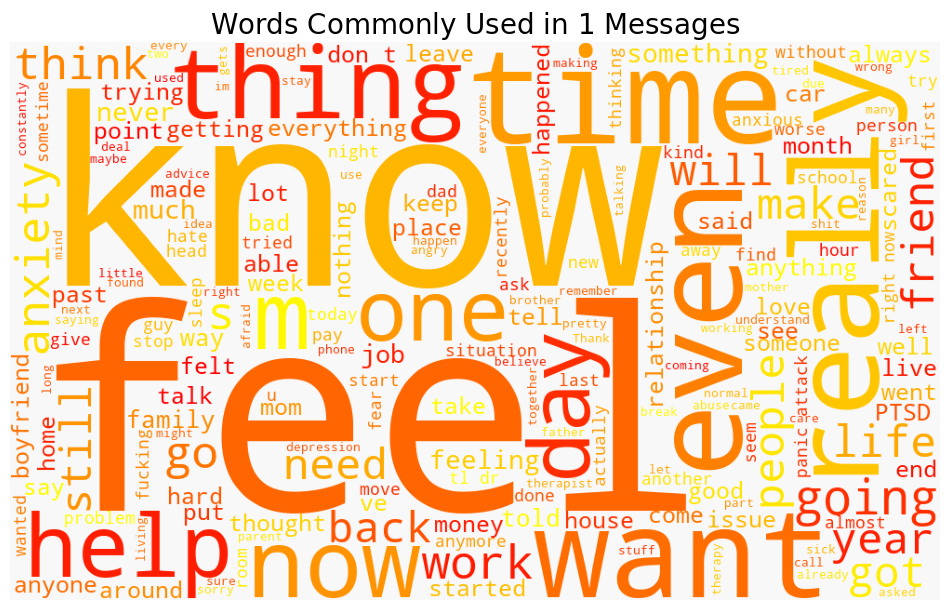

In [34]:
for label, cmap in zip([0,1],
                       ['winter', 'autumn', 'magma', 'viridis', 'plasma']):
    text = df.query('label == @label')['text'].str.cat(sep=' ')
    plt.figure(figsize=(12, 9))
    wc = WordCloud(width=1000, height=600, background_color="#f8f8f8", colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${label}$ Messages", size=20)
    plt.show()

## Prediction ##

In [35]:
data = ["""I don't have the ability to cope with it anymore. I'm trying, but a lot of things are triggering me, 
and I'm shutting down at work, just finding the place I feel safest, and staying there for an hour or two until 
I feel like I can do something again. I'm tired of watching my back, tired of traveling to places I don't feel safe, 
tired of reliving that moment, tired of being triggered, tired of the stress, tired of anxiety and knots in my stomach, 
tired of irrational thought when triggered, tired of irrational paranoia. I'm exhausted and need a break, but know it won't be 
enough until I journey the long road through therapy. I'm not suicidal at all, just wishing this pain and misery would end, to have my life back again."""]

In [ ]:
# Transform the text using your vectorizer
data_transformed = vector.transform(data)

In [39]:
# Get prediction probabilities
probabilities = model_lr_tf.predict_proba(data_transformed)

# Extract the "stressed" probability (class 1)
stress_probs = probabilities[:, 1]
for i, prob in enumerate(stress_probs):
    print(f"Text {i+1} - Stress Probability: {prob:.2f} {'(Stressed)' if prob > 0.5 else '(Non-Stressed)'}")

Text 1 - Stress Probability: 0.86 (Stressed)
